This Jupyter Notebook provide the beginning of the treatment of the data. This will be useful for the whole project. \\
First, we will wrangle the data. This section will form an intresting dataFrame that will allows us to master the data afterward.
For the begining of the project, only the revenues of the movies will be useful as well as the character and their participation of the various films.

In [103]:
import pandas as pd
import numpy as np
dataFrame_movie = pd.read_csv("../MovieSummaries/movie.metadata.tsv",delimiter='\t') 
dataFrame_movie.columns = ['Wikipedia ID', 'Freebase ID', 'Name', 'Release Date', 'Revenue', 'Run Time', 'Language', 'Countries', 'Genres']

dataFrame_character = pd.read_csv("../MovieSummaries/character.metadata.tsv",delimiter='\t') 
dataFrame_character.columns = ['Wikipedia ID', 'Freebase ID', 'Release Date', 'Character Name', 'Actor Birth', 'Actor Gender', 'Actor Height', 'Ethnicity', 'Actor Name', 'Actor Age At Movie Release', 'Freebase Actor/Character Map ID', 'Freebase Character ID', 'Freebase Actor ID']




We have now our 2 dataframes. First, We will drop the NA in the revenue. We need to have the revenues of the movie we are working with. 

In [104]:
dataFrame_movie = dataFrame_movie.dropna(subset=['Revenue'])

First, we are counting the number of actor per film (actor = character) 

In [105]:
df_count = dataFrame_movie.merge(dataFrame_character, on = 'Wikipedia ID', how = 'left') # POPULATE EACH MOVIE WITH ACTOR 
counter = df_count.groupby('Wikipedia ID')['Actor Name'].nunique() # We count the number of actor per movie

In [106]:
df_count

,Wikipedia ID,Freebase ID_x,Name,Release Date_x,Revenue,Run Time,Language,Countries,Genres,Freebase ID_y,...,Character Name,Actor Birth,Actor Gender,Actor Height,Ethnicity,Actor Name,Actor Age At Movie Release,Freebase Actor/Character Map ID,Freebase Character ID,Freebase Actor ID
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,...,NaN,1908-01-16,F,NaN,NaN,Ethel Merman,30.0,/m/02vctvm,NaN,/m/0pkw7
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,...,Roger Grant AKA Alexander,1914-05-05,M,1.820,/m/06v41q,Tyrone Power,24.0,/m/02vbvj2,/m/0h36wrs,/m/02s58t
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,...,NaN,1915-05-05,F,1.650,/m/033tf_,Alice Faye,23.0,/m/02vbq8t,NaN,/m/032xfz
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",/m/02qc0j7,...,NaN,1908-05-31,M,1.791,NaN,Don Ameche,30.0,/m/02vbjy4,NaN,/m/02l0xc
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",/m/016ywb,...,Henry V,1960-12-10,M,1.770,/m/0d7wh,Kenneth Branagh,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101184,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/030xw6,...,NaN,1956-08-28,M,1.710,/m/0gkxl2,Luis Guzmán,36.0,/m/0cgb0nt,NaN,/m/031f1q
101185,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/030xw6,...,NaN,1920-09-18,M,1.790,NaN,Jack Warden,72.0,/m/0cg3s58,NaN,/m/02wr6r
101186,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/030xw6,...,NaN,1935-09-24,M,NaN,/m/044038p,Sean McCann,57.0,/m/0cg1r2m,NaN,/m/06w_1w
101187,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",/m/030xw6,...,NaN,1959-03-08,F,NaN,NaN,Barbara Eve Harris,34.0,/m/0gccw65,NaN,/m/0gsvr7


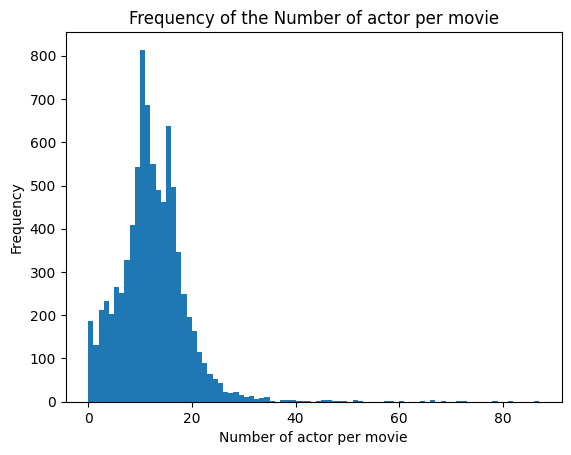

In [107]:
import matplotlib.pyplot as plt


plt.hist(counter, bins =max(counter))

plt.title('Frequency of the Number of actor per movie')
plt.xlabel('Number of actor per movie')
plt.ylabel('Frequency')
plt.show()


Now, the idea is to create a matrix. Each row of the matrix represent a differente movie. Every Column represents a different actor. The matrix returns 1 if the actor i plays in the movie j and 0 otherwise

In [108]:
# Create a binary matrix where rows represent movies, columns represent actors
binary_matrix = df_count.pivot_table(index='Name', columns='Actor Name', aggfunc='size', fill_value=0)

# Reset the index to have movie name as a column
binary_matrix = binary_matrix.reset_index()

# Fill NaN values with 0 (if necessary)
binary_matrix = binary_matrix.fillna(0)

# Rename the columns with a prefix for clarity
binary_matrix.columns = ['Name'] + [ str(col) for col in binary_matrix.columns[1:]]

# Set 'movie name' as the index 
binary_matrix.set_index('Name', inplace=True)

In [109]:
binary_matrix

,'Squeeks' the Caterpillar,40 Glocc,50 Cent,A Martinez,A. Delon Ellis Jr.,A. J. Benza,A. J. Bowen,A. J. Buckley,A. J. Cook,A. J. Langer,...,Þrúður Vilhjálmsdóttir,İdil Fırat,İsmail Hacıoğlu,Şafak Sezer,Şebnem Dönmez,Şener Şen,Şevval Sam,Željko Ivanek,佐々木望,田村英里子
Name,,,,,,,,,,,,,,,,,,,,,
'Til There Was You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*batteries not included,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...And Justice for All,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoom,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zoot Suit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
¡Three Amigos!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have to much actor right now, therefore we have to get rid of many of them

Using this matrix, we will remove the actors that appears in less than 35 movies 

In [114]:
actor_sum=binary_matrix.sum()
actors_to_drop=actor_sum[actor_sum<35].index

In [111]:
filtered_binary_matrix=binary_matrix.drop(actors_to_drop,axis=1)


In [112]:
filtered_binary_matrix  

,Bruce Willis,Christopher Walken,Danny DeVito,Dennis Quaid,Donald Sutherland,Eddie Murphy,Frank Welker,Gene Hackman,John Cusack,John Goodman,...,Nicolas Cage,Richard Jenkins,Robert De Niro,Robert Downey Jr.,Robin Williams,Samuel L. Jackson,Steve Buscemi,Susan Sarandon,Tom Hanks,Willem Dafoe
Name,,,,,,,,,,,,,,,,,,,,,
'Til There Was You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*batteries not included,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...And Justice for All,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoom,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zoot Suit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
¡Three Amigos!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
for i in filtered_binary_matrix.columns.tolist():
    print(i)

Bruce Willis
Christopher Walken
Danny DeVito
Dennis Quaid
Donald Sutherland
Eddie Murphy
Frank Welker
Gene Hackman
John Cusack
John Goodman
John Hurt
John Turturro
Liam Neeson
Morgan Freeman
Nicolas Cage
Richard Jenkins
Robert De Niro
Robert Downey Jr.
Robin Williams
Samuel L. Jackson
Steve Buscemi
Susan Sarandon
Tom Hanks
Willem Dafoe


Even with this filter, we still have a high number of actor (113). This is still a high number and if we want to test every pair of actor as a independant variable, we need (113*112)/2 beta. We still have the possibility to filter more using maybe more qualitative aspect. 

An important aspect that we have to care about is the interaction between actors. We build now the matrix of interraction between actors with more than 25 films. (Why 25? because it is better to have a bigger number of actor) 

In [115]:
actors_to_drop=actor_sum[actor_sum<25].index

filtered_binary_matrix=binary_matrix.drop(actors_to_drop,axis=1)

filtered_binary_matrix


,Adam Sandler,Adrien Brody,Aidan Quinn,Al Pacino,Alan Arkin,Alan Cumming,Alan Rickman,Alec Baldwin,Alfred Molina,Allison Janney,...,Whoopi Goldberg,Will Ferrell,Will Patton,Willem Dafoe,William H. Macy,William Hurt,Winona Ryder,Woody Allen,Woody Harrelson,Xander Berkeley
Name,,,,,,,,,,,,,,,,,,,,,
'Til There Was You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(500) Days of Summer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*batteries not included,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...And Justice for All,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoom,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zoot Suit,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
¡Three Amigos!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For each column of the filtered_binary_matrix, we multiply by every other column and them sum the new column

In [159]:
binary_matrix_column = filtered_binary_matrix.columns


matrix = np.zeros([len(binary_matrix_column),len(binary_matrix_column)])

i = 0
j = 0
# Iteration in every row and column to calculate the interaction
for col in binary_matrix_column:
    result = []
    j = 0
    for col2 in binary_matrix_column:
        #since the column are dummies, we can just multiply
        matrix[i,j]= (filtered_binary_matrix[col]* filtered_binary_matrix[col2]).sum()
        j+= 1
    i+=1

# We put the result in a dataframe
pairing_df = pd.DataFrame(matrix, columns=binary_matrix_column, index=binary_matrix_column)




We have our matrix of interaction. We will sort a list of actor that interract the most with his pear. We set the diagonal of the matrix equal to 0 and count the number of interaction of each actor

In [170]:
matrix_interaction = matrix - matrix*np.eye(len(binary_matrix_column))
pure_interaction = pd.DataFrame(matrix_interaction, columns=binary_matrix_column, index=binary_matrix_column)

pure_interaction = pure_interaction.sum(axis =1)

pure_interaction.sort_values(ascending=False)


Steve Buscemi        200.0
Samuel L. Jackson    179.0
Hank Azaria          173.0
Bruce Willis         166.0
Tom Hanks            163.0
                     ...  
Keenan Wynn           18.0
Katharine Hepburn     15.0
James Mason           14.0
James Stewart         12.0
Ginger Rogers          5.0
Length: 367, dtype: float64

Now we have a list of actors who collaborate most frequently with their peers.


Additional Idea : We should maybe draw a map of the connection between actor to get rid of interration between actor that have never worked together. We should maybe add more women (even if their number of film is lower). We could maybe see an intresting trend
We could also use other types of variable such as the age difference between the actors